# GaitRehab Explanatory Data Analysis

In [2]:
# Libraries
import os, sys, math, random, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt

# Display settings
plt.rcParams['figure.figsize'] = (15, 5)

# Constants
data_path = "/Users/stamatiosorphanos/Documents/GaitRehab_Models/data"
healthy_directory = os.path.join(data_path, "Healthy")

stroke_directory  = os.path.join(data_path, "Stroke")

positions_dict = {}

## Inertial Measurement Unit - IMU EDA

1. ELT process and standarization of data format
2. Plot data and provide explorations


In [3]:
# Renaming and standardizing the files
for subdir, dirs, files in os.walk(healthy_directory):
    for file in files:
        file_path = os.path.join(healthy_directory, file)
        formatted_name = file.replace(" ", "").replace("-", "_")
        sensors_position = formatted_name.split("_")[0]
        device = formatted_name.split("_")[-1].split(".")[0]
        date = "/".join(formatted_name.split("T")[0].split("_")[1:4])
        print(subdir + "\t" + device + "\t" + sensors_position + "\t" + date)
        new_name = file.split("_")[0] +  ".csv"     
    

/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1	Trial02	Vicon	
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Accelerometer	E3	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Gyroscope	Meta47D	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Accelerometer	CF	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Gyroscope	Meta1	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Accelerometer	Meta1	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Accelerometer	3D	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Gyroscope	CF	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU	Accelerometer	MetaWear	2022/01/19
/Users/stamatiosorphanos/Documents/GaitRehab_Mode

In [4]:
imu_df = pd.read_csv("/Users/stamatiosorphanos/Documents/GaitRehab_Models/data/Healthy/Patient_1/IMU/3D-2022-01-19T10.53.38.171-F0794D73E83D-Accelerometer.csv")
imu_df[['x-axis (g)', 'y-axis (g)', 'z-axis (g)']] = imu_df[['x-axis (g)', 'y-axis (g)', 'z-axis (g)']] / 1000.0
imu_df['time (s)'] = imu_df['elapsed (s)'] / 1000.0

imu_df.head()

,epoc (ms),timestamp (+0700),elapsed (s),x-axis (g),y-axis (g),z-axis (g),time (s)
0,1642564423045,2022-01-19T10.53.43.045,0.00,0.000948,0.000057,-0.000152,0.00000
1,1642564423055,2022-01-19T10.53.43.055,0.01,0.000957,0.000060,-0.000157,0.00001
2,1642564423065,2022-01-19T10.53.43.065,0.02,0.000951,0.000063,-0.000162,0.00002
3,1642564423075,2022-01-19T10.53.43.075,0.03,0.000950,0.000064,-0.000163,0.00003
4,1642564423085,2022-01-19T10.53.43.085,0.04,0.000952,0.000063,-0.000160,0.00004


### Plot Raw IMU Accelerometer Signals

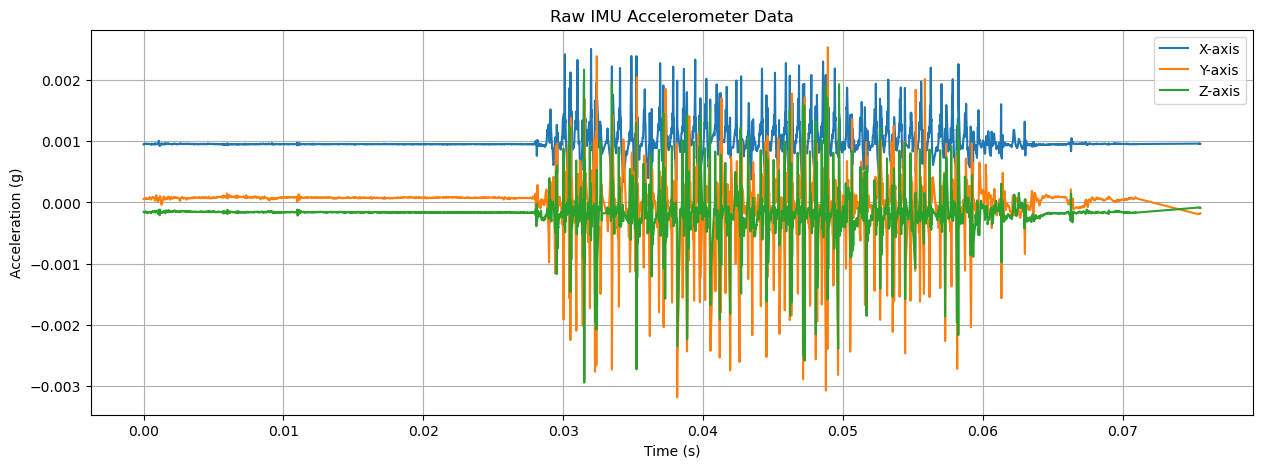

In [5]:
plt.plot(imu_df['time (s)'], imu_df['x-axis (g)'], label='X-axis')
plt.plot(imu_df['time (s)'], imu_df['y-axis (g)'], label='Y-axis')
plt.plot(imu_df['time (s)'], imu_df['z-axis (g)'], label='Z-axis')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Raw IMU Accelerometer Data")
plt.legend()
plt.grid(True)
plt.show()


### Low-Pass Filter for IMU

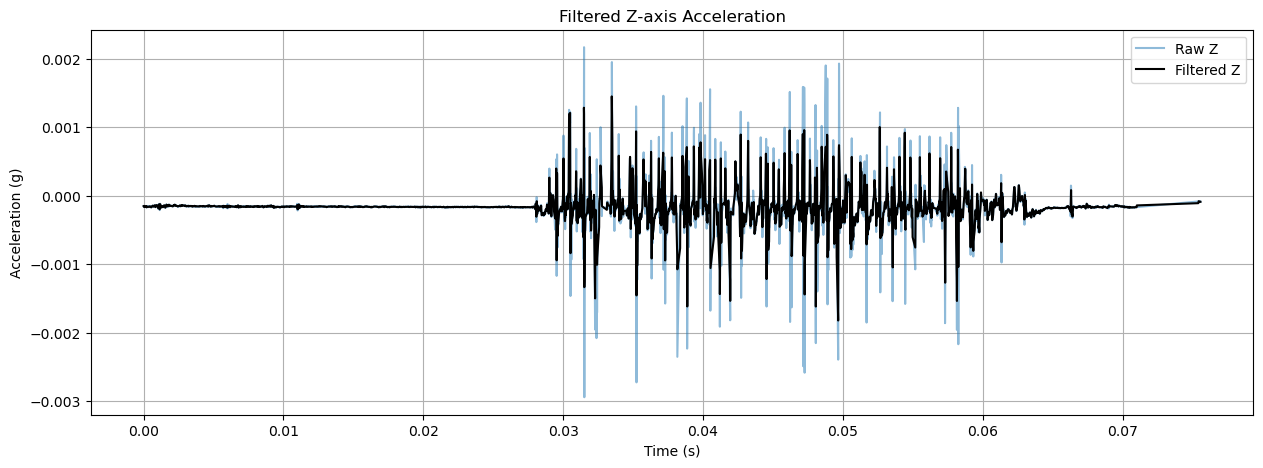

In [6]:
def butter_lowpass_filter(data, cutoff=20, fs=100, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

imu_df['z-axis (filtered)'] = butter_lowpass_filter(imu_df['z-axis (g)'])

plt.plot(imu_df['time (s)'], imu_df['z-axis (g)'], alpha=0.5, label='Raw Z')
plt.plot(imu_df['time (s)'], imu_df['z-axis (filtered)'], label='Filtered Z', color='black')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Filtered Z-axis Acceleration")
plt.legend()
plt.grid(True)
plt.show()


### Load Vicon Analog + EMG Data

In [12]:
vicon_df = pd.read_csv("data/Healthy/Patient_1/Vicon_Trial02.csv", skiprows=12, delimiter=',')
vicon_df.columns = vicon_df.columns.str.strip()

# Ensure 'Time (s)' column exists
if 'Time (s)' not in vicon_df.columns:
	vicon_df['Time (s)'] = vicon_df.index / 1000.0

# EMG Plot Example
emg_cols = [col for col in vicon_df.columns if 'EMG1' in col]
if emg_cols:  # Ensure there are EMG columns to plot
	vicon_df.plot(x='Time (s)', y=emg_cols[:4], title="Sample EMG Channels (Raw)")
	plt.xlabel("Time (s)")
	plt.ylabel("Voltage (V)")
	plt.grid(True)
	plt.show()
else:
	print("No EMG columns found in the dataframe.")



No EMG columns found in the dataframe.
